In [414]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
import re
lemmatizer = WordNetLemmatizer() 

In [415]:
data = pd.read_csv('data.csv')
demos = pd.read_csv('demos_data.csv')

In [416]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 16 columns):
id                              252 non-null int64
ad_creation_time                252 non-null object
ad_creative_body                249 non-null object
ad_creative_link_caption        131 non-null object
ad_creative_link_description    90 non-null object
ad_creative_link_title          168 non-null object
ad_delivery_start_time          252 non-null object
ad_delivery_stop_time           249 non-null object
ad_snapshot_url                 252 non-null object
currency                        252 non-null object
funding_entity                  250 non-null object
page_id                         252 non-null int64
page_name                       252 non-null object
impression_range                252 non-null object
spend_range                     252 non-null object
platforms                       252 non-null object
dtypes: int64(2), object(14)
memory usage: 31.6+ KB


In [417]:
data.head(3)

,id,ad_creation_time,ad_creative_body,ad_creative_link_caption,ad_creative_link_description,ad_creative_link_title,ad_delivery_start_time,ad_delivery_stop_time,ad_snapshot_url,currency,funding_entity,page_id,page_name,impression_range,spend_range,platforms
0,499844334269818,2019-12-11T13:54:18+0000,Every vote counts - Vote DODDS X,NaN,NaN,NaN,2019-12-12T00:01:59+0000,2019-12-12T21:59:59+0000,https://www.facebook.com/ads/archive/render_ad...,GBP,Democratic Unionist Party,105732052794210,Democratic Unionist Party,"3000,3999","0,99","facebook,instagram"
1,453850975333442,2019-12-10T16:36:40+0000,The DUP is the only party with a positive plan...,www.mydup.com,NaN,The DUP has a positive plan for NI,2019-12-10T16:36:40+0000,2019-12-12T16:36:29+0000,https://www.facebook.com/ads/archive/render_ad...,GBP,Democratic Unionist Party,105732052794210,Democratic Unionist Party,"25000,29999","200,299","facebook,instagram"
2,442557686431595,2019-12-10T16:23:32+0000,A vote for the DUP is a vote to get Northern I...,www.mydup.com,NaN,Vote to get NI moving again,2019-12-10T16:23:32+0000,2019-12-12T16:23:20+0000,https://www.facebook.com/ads/archive/render_ad...,GBP,Democratic Unionist Party,105732052794210,Democratic Unionist Party,"15000,19999","100,199","facebook,instagram"


## Pre Processing
1. Parse ad_delivery_start_time to datetime
2. Filter on election timeline 
3. impression & spend range converted to numeric averages 

In [418]:
data['ad_date'] = pd.to_datetime(data.ad_delivery_start_time.str.slice(start=0, stop=10))

In [419]:
data = data[(data['ad_date'] > '2019-11-06') & (data['ad_date'] < '2019-12-12')]

In [420]:
spend_range = [[int(range_[0]), int(range_[1])] for range_ in data.spend_range.str.split(',')]
data['spend'] = list(map(lambda x: sum(x)/2, spend_range))
impression_range = [[int(range_[0]), int(range_[1])] for range_ in data.impression_range.str.split(',')]
data['impressions'] = list(map(lambda x: sum(x)/2, impression_range))

## Analysis

#### What was the cumulative spend by party and what did they pay for?

In [421]:
vis_1 = data.groupby(['ad_date', 'page_name'])['spend', 'impressions'].sum()\
.groupby('page_name').cumsum().reset_index().melt(id_vars=['ad_date', 'page_name'])

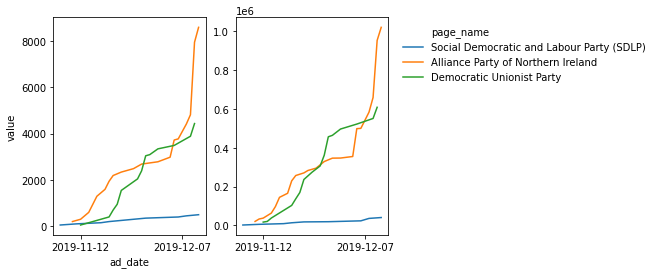

In [422]:
fig, ax = plt.subplots(1,2, sharex=True)
ax1 = sns.lineplot(data=vis_1[vis_1['variable']=='spend'],
             x='ad_date', y='value', hue='page_name', 
            legend=False, ax=ax[0])
ax2 = sns.lineplot(data=vis_1[vis_1['variable']=='impressions'],
             x='ad_date', y='value', hue='page_name', 
            legend='brief', ax=ax[1])
ax1.xaxis.set_major_locator(plt.MaxNLocator(1))
plt.xlabel("")
plt.ylabel("");
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", frameon=False)

#### What was the aggregate demographic distribution targed by each campaign?

In [423]:
demographics = demos.merge(right=data[['id', 'impressions', 'page_name']],how='left')
demographics['impress_per_demo'] = demographics.percentage * demographics.impressions

In [424]:
vis_2 = demographics.groupby(['age', 'page_name'], as_index=False)['impress_per_demo'].sum()
fig_2 = px.bar(vis_2, x='age', y='impress_per_demo', facet_row='page_name', color='page_name',
               labels={'age': '', 'impress_per_demo': '','page_name':''},
               title='2019 FB Impressions by Age Band')
fig_2.layout.yaxis1.update(matches=None)
fig_2.layout.yaxis2.update(matches=None)
fig_2.layout.yaxis3.update(matches=None)
fig_2.for_each_annotation(lambda a: a.update(text=''))
fig_2.show()

#### What was the campaign message, did it change by demographic?


In [425]:
def preprocess_text(text):
    text = str(text)
    text = re.sub(r'\n', '', text) # Remove new line markers
    text = re.sub(r'[^a-zA-z\s]', '', text) # Remove special characters
    text = text.lower() # To lower case
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()]) # Lemmatizatise words
    text = ' '.join([word for word in text.split() if word not in stopwords.words('english')]) # Remove stop words
    return text

In [426]:
data.dropna(subset=['ad_creative_body'], inplace=True) # Three Alliance ads with no body, removed
data['body'] = data.ad_creative_body.apply(preprocess_text) 

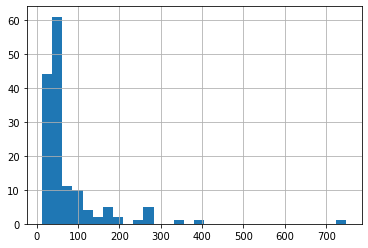

In [427]:
# Remove ads with over 300 characters in their body, inclusion will skew wordcloud
data.body.str.len().hist(bins=30)
data = data[data.body.str.len() < 300]

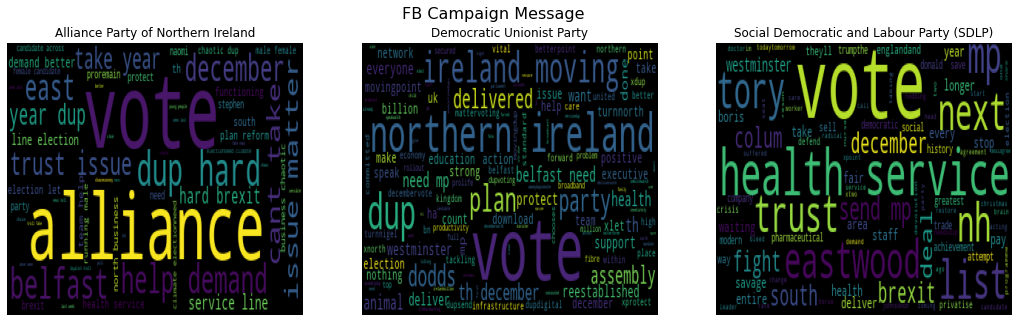

In [428]:
vis_3 = data.groupby('page_name')['body'].sum()
fig, ax = plt.subplots(1, 3, sharey=True, figsize=(18, 5))
for i in range(3):
    ax[i].imshow(WordCloud().generate(vis_3.iloc[i]), aspect='auto')
    ax[i].set_title(vis_3.index[i])
    ax[i].axis('off')
fig.suptitle('FB Campaign Message', fontsize=16)
plt.show()